# Processing a LIVECell Dataset
If you have already accomplished steps 1-2, then you can skip the executions of this notebook to Project to latent space and run the first cell in `Start here...`

If you have not, skip the `Start here...` cell to the `Continue Plotting Results Here` cell

## 1. Load Segmentations to Matlab Files
1. Set the desired cell line in the `Boilerplate` section, cell #3 out of the list: `["MCF7", "A172", "BT474", "BV-2", "Huh7", "SkBr3", "SK-OV-3", "SH-SY5Y"]`
2. Run the cells from `Boilerplate` through `Prepare Segmentations for MATLAB`

## 2. Process Segmentations to Morphologies
Execute the `Run Matlab Process Script` cells
 - If `matlab` is not available in the same environment, copy the segmentation `*.mat` files to the machine with MATLAB, process the files there, then copy the `svm`, or desired output folder, back to the machine with the Jupyter session
 
## 3. Visualize Results
Execute `Project to Latent Space` to `END` cells

# Boilerplate

In [2]:
import numpy as np
from scipy.io import loadmat, savemat
import pickle
import pandas as pd
import json
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
from os.path import abspath

In [3]:
# MCF7, Huh7, SK-OV-3, SkBr3, BT474

In [4]:
BASE="https://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_single_cells/"
CELL="MCF7"
DATASET="test"

In [54]:
SAVE_EXTRAS = False
g_Base = lambda *args: DIR_ROOT + f"Figures/LIVECell/{CELL}_{DATASET}/"

In [5]:
BASE_FOLDER = "../../LIVECell/"

# Download Test Dataset

In [374]:
!mkdir -p "{BASE_FOLDER}{CELL}/"
!curl -o "{BASE_FOLDER}{CELL}/{CELL.lower()}_{DATASET}.json" "{BASE}{CELL.lower()}/{DATASET}.json"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44.0M  100 44.0M    0     0  4078k      0  0:00:11  0:00:11 --:--:-- 4814k


In [21]:
with open(f"{BASE_FOLDER}{CELL}/{CELL.lower()}_{DATASET}.json", "r") as fhandle:
    cell_data = json.load(fhandle)

In [22]:
cell_data['images'][0].keys()

dict_keys(['url', 'file_name', 'height', 'width', 'original_filename', 'id'])

# Segment Dataset

In [23]:
widths = [cell_data['images'][i]['width'] for i in range(len(cell_data['images']))]
heights = [cell_data['images'][i]['width'] for i in range(len(cell_data['images']))]
image_ids = set([cell_data['images'][i]['id'] for i in range(len(cell_data['images']))])
W,H = max(widths), max(heights)
W,H

(704, 704)

In [24]:
cell_image_ids = set([cell_data['annotations'][i]['image_id'] for i in range(len(cell_data['annotations']))])
category_ids = set([cell_data['annotations'][i]['category_id'] for i in range(len(cell_data['annotations']))])
cell_ids = set([cell_data['annotations'][i]['id'] for i in range(len(cell_data['annotations']))])

In [25]:
len(image_ids),len(cell_image_ids),len(image_ids&cell_image_ids),len(category_ids),len(cell_ids)

(184, 184, 184, 1, 96914)

In [ ]:
segmentations = np.zeros((len(image_ids),W,H), dtype=np.uint64)
for segmentation_number, IMAGE_ID in tqdm(list(enumerate(image_ids))):
    segmentation_cell_number = 1
    segmentation = np.zeros((W,H))
    for cell_annotation in (cell_data['annotations']):
        if cell_annotation['image_id'] != IMAGE_ID:
            continue
        segmentation_list = np.array(cell_annotation['segmentation']).reshape((-1,2))
        segmentation_list = np.vstack([segmentation_list, segmentation_list[0,:]]).astype(np.int64).reshape((-1,1,2))
        image = np.zeros((W,H))
        cv2.drawContours(image, [segmentation_list], 0, (255,0,0), thickness=-1)
        image = image.astype(np.bool_)
        image = image.astype(np.uint64)*segmentation_cell_number
        segmentation[segmentation==0] += image[segmentation==0]
        segmentation_cell_number += 1
    segmentations[segmentation_number,...] = segmentation

In [418]:
with open(f"{BASE_FOLDER}{CELL}/{DATASET}.pkl", "wb+") as fhandle:
    pickle.dump(segmentations.tolist(),fhandle)

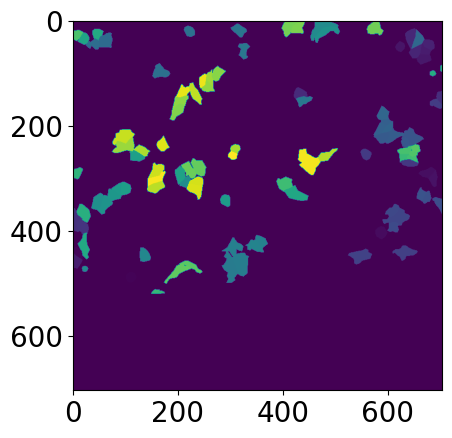

In [28]:
plt.imshow(segmentations[-1,...])

# Prepare Segmentations for MATLAB

In [382]:
!mkdir -p "{BASE_FOLDER}{CELL}/detections/"
!mkdir -p "{BASE_FOLDER}{CELL}/svm/"

In [26]:
import operator
image_file_names = [(cell_data['images'][i]['id'],*cell_data['images'][i]['file_name'].split("_")) for i in range(len(cell_data['images']))]
image_file_names = [(*x[:4],int(x[4]),int(x[5][:2]),int(x[5][3:5]),int(x[5][6:8]),int(x[6][:-4]),x[6][-4:]) for x in image_file_names]
sorted_ifn = sorted(image_file_names, key=operator.itemgetter(3,4,8,5,6,7))

In [27]:
fid_to_name = {x[0]: '_'.join([x[1],x[2],x[3],f"{x[4]}",f"{x[5]:02}d{x[6]:02}h{x[7]:02}m",f"{x[8]}{x[9]}"]) for x in sorted_ifn}
{list(fid_to_name.keys())[i]:fid_to_name[list(fid_to_name.keys())[i]] for i in range(10)}

{553662: 'MCF7_Phase_H4_1_00d00h00m_1.tif',
 619052: 'MCF7_Phase_H4_1_00d04h00m_1.tif',
 613599: 'MCF7_Phase_H4_1_00d08h00m_1.tif',
 564378: 'MCF7_Phase_H4_1_00d12h00m_1.tif',
 605389: 'MCF7_Phase_H4_1_00d16h00m_1.tif',
 559767: 'MCF7_Phase_H4_1_00d20h00m_1.tif',
 543620: 'MCF7_Phase_H4_1_01d00h00m_1.tif',
 543920: 'MCF7_Phase_H4_1_01d04h00m_1.tif',
 616450: 'MCF7_Phase_H4_1_01d08h00m_1.tif',
 606171: 'MCF7_Phase_H4_1_01d12h00m_1.tif'}

In [28]:
sorted_ifn_np = np.array(sorted_ifn)
np.unique(sorted_ifn_np[:,[3,4,-2]], axis=0)

array([['H4', '1', '1'],
       ['H4', '1', '2'],
       ['H4', '1', '3'],
       ['H4', '1', '4'],
       ['H4', '2', '1'],
       ['H4', '2', '2'],
       ['H4', '2', '3'],
       ['H4', '2', '4']], dtype='<U21')

In [29]:
for FILTER in np.unique(sorted_ifn_np[:,[3,4,-2]], axis=0):
    increasing_frame_ids = [x[0] for x in sorted_ifn if (x[3] == FILTER[0]) and (x[4] == int(FILTER[1])) and (x[-2] == int(FILTER[2]))]
    frame_id_idx_dict = {x[1]:x[0] for x in enumerate(cell_image_ids) if x[1] in increasing_frame_ids}
    increasing_frames = [frame_id_idx_dict[i] for i in increasing_frame_ids]
    if len(increasing_frames) == 0:
        continue
    if max(increasing_frames) < len(image_ids):
        break
FILTER

array(['H4', '1', '1'], dtype='<U21')

In [30]:
FILTER = [i for i in FILTER]
increasing_frame_ids = [x[0] for x in sorted_ifn if (x[3] == FILTER[0]) and (x[4] == int(FILTER[1])) and (x[-2] == int(FILTER[2]))]

In [31]:
frame_id_idx_dict = {x[1]:x[0] for x in enumerate(cell_image_ids) if x[1] in increasing_frame_ids}

In [32]:
increasing_frames = [frame_id_idx_dict[i] for i in increasing_frame_ids]
len(increasing_frames)

23

In [397]:
!ls "{BASE_FOLDER}{CELL}/detections/"

In [398]:
!rm "{BASE_FOLDER}{CELL}/detections/"*
!rm "{BASE_FOLDER}{CELL}/svm/"*

rm: cannot remove ‘../../LIVECell/MCF7/detections/*’: No such file or directory
rm: cannot remove ‘../../LIVECell/MCF7/svm/*’: No such file or directory


In [399]:
for idx,seg_idx in enumerate(increasing_frames):
    label_data = segmentations[seg_idx,...]
    savemat(f"{BASE_FOLDER}{CELL}/detections/Image_{idx:03}.mat",
           dict(image=[], labels=label_data.astype(np.uint32)))

# Run Matlab Process Script
1. Update save and mat dirs in CellTrack_DL.m
2. `matlab -nodisplay -nosplash -nodesktop -r "run('./Matlab/CellTrack_DL.m');exit;"`

In [6]:
MAT_PATH=abspath(f"{BASE_FOLDER}{CELL}/detections/") + "/"
SAVE_PATH=abspath(f"{BASE_FOLDER}{CELL}/svm/") + "/"

In [142]:
!matlab -batch "save_path='{SAVE_PATH}';mat_path='{MAT_PATH}';run('../../Matlab/CellTrack_DL.m');exit;"

MATLAB is selecting SOFTWARE OPENGL rendering.
Selecting from/home/physics/cunnichr/NewKeras/LIVECell/MCF7/svm//home/physics/cunnichr/NewKeras/LIVECell/MCF7/detections/

Matnames = 

  23x1 struct array with fields:

    name
    folder
    date
    bytes
    isdir
    datenum

Reading Image_000.mat
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
Reading Image_001.mat
Reading Image_002.mat
Reading Image_003.mat
Reading Image_004.mat
Reading Image_005.mat
Reading Image_006.mat
Reading Image_007.mat
Reading Image_008.mat
Reading Image_009.mat
Reading Image_010.mat
Reading Image_011.mat
Reading Image_012.mat
Reading Image_013.mat
Reading Image_014.mat
Reading Image_015.mat
Reading Image_016.mat
Reading Image_017.mat
Reading Image_018.mat
Reading Image_019.mat
Reading Image_020.mat
Reading Image_021.mat
Reading Image_022.mat
Complete :)
Please run Detect_Errors.m and ChangeCellNum.m if necessary
Complete :)
Please run Detect_Errors.m

# Project to Latent Space

In [ ]:
assert False, "Checkpoint"

## Start from here if segmentations have already been processed to morphologies

In [1]:
import numpy as np
from scipy.io import loadmat, savemat
import pickle
import pandas as pd
import json
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
from os.path import abspath

# MCF7, Huh7, SK-OV-3, SkBr3, BT474

BASE="https://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_single_cells/"
CELL="MCF7"
DATASET="test"

SAVE_EXTRAS = False
g_Base = lambda *args: DIR_ROOT + f"Figures/LIVECell/{CELL}_{DATASET}/"

BASE_FOLDER = "../../LIVECell/"

with open(f"{BASE_FOLDER}{CELL}/{CELL.lower()}_{DATASET}.json", "r") as fhandle:
    cell_data = json.load(fhandle)

widths = [cell_data['images'][i]['width'] for i in range(len(cell_data['images']))]
heights = [cell_data['images'][i]['width'] for i in range(len(cell_data['images']))]
image_ids = set([cell_data['images'][i]['id'] for i in range(len(cell_data['images']))])
W,H = max(widths), max(heights)
W,H

cell_image_ids = set([cell_data['annotations'][i]['image_id'] for i in range(len(cell_data['annotations']))])
category_ids = set([cell_data['annotations'][i]['category_id'] for i in range(len(cell_data['annotations']))])
cell_ids = set([cell_data['annotations'][i]['id'] for i in range(len(cell_data['annotations']))])

import operator
image_file_names = [(cell_data['images'][i]['id'],*cell_data['images'][i]['file_name'].split("_")) for i in range(len(cell_data['images']))]
image_file_names = [(*x[:4],int(x[4]),int(x[5][:2]),int(x[5][3:5]),int(x[5][6:8]),int(x[6][:-4]),x[6][-4:]) for x in image_file_names]
sorted_ifn = sorted(image_file_names, key=operator.itemgetter(3,4,8,5,6,7))

fid_to_name = {x[0]: '_'.join([x[1],x[2],x[3],f"{x[4]}",f"{x[5]:02}d{x[6]:02}h{x[7]:02}m",f"{x[8]}{x[9]}"]) for x in sorted_ifn}
{list(fid_to_name.keys())[i]:fid_to_name[list(fid_to_name.keys())[i]] for i in range(10)}

sorted_ifn_np = np.array(sorted_ifn)
np.unique(sorted_ifn_np[:,[3,4,-2]], axis=0)

# Skip filtering if you want all image sessions (May take a long time)

for FILTER in np.unique(sorted_ifn_np[:,[3,4,-2]], axis=0):
    increasing_frame_ids = [x[0] for x in sorted_ifn if (x[3] == FILTER[0]) and (x[4] == int(FILTER[1])) and (x[-2] == int(FILTER[2]))]
    frame_id_idx_dict = {x[1]:x[0] for x in enumerate(cell_image_ids) if x[1] in increasing_frame_ids}
    increasing_frames = [frame_id_idx_dict[i] for i in increasing_frame_ids]
    if len(increasing_frames) == 0:
        continue
    if max(increasing_frames) < len(image_ids):
        break
FILTER

FILTER = [i for i in FILTER]
increasing_frame_ids = [x[0] for x in sorted_ifn if (x[3] == FILTER[0]) and (x[4] == int(FILTER[1])) and (x[-2] == int(FILTER[2]))]

# Continue and run the following commented line if no filter is necessary
# increasing_frame_ids = [x[0] for x in sorted_ifn]

frame_id_idx_dict = {x[1]:x[0] for x in enumerate(cell_image_ids) if x[1] in increasing_frame_ids}

increasing_frames = [frame_id_idx_dict[i] for i in increasing_frame_ids]
len(increasing_frames)

23

In [2]:
def load():
    with open(f"{BASE_FOLDER}{CELL}/{DATASET}.pkl", "rb") as fhandle:
        segmentations = pickle.load(fhandle)
    segmentations = np.array(segmentations)
    return segmentations
try:
    _ = segmentations
except:
    segmentations = load()

## Continue Plotting Results Here

In [3]:
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.globals import FILES
from sunlab.sunflow import *

In [4]:
from sunlab.svm import *

In [5]:
test_magnifications = np.array([1,2,4,8,10,20,40])
target_area = 200
temp_dataset = process_and_load_dataset(f"{BASE_FOLDER}{CELL}/svm/svm.csv", FILES['PRETRAINED_MODEL_DIR'])
area = temp_dataset.dataframe["Area"].mean()
magnifications = test_magnifications[np.argsort(np.abs(target_area - area/(test_magnifications/10)))]
magnifications

/home/physics/cunnichr/NewKeras/sunlab/code/sunlab/common/data/dataset.py:84: RuntimeWarning: No classification labels found for the dataset
  warnings.warn(


array([20, 10, 40,  8,  4,  2,  1])

In [6]:
model = load_aae(FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)

In [7]:
magnification = 10
cell_line_dataset = process_and_load_dataset(f"{BASE_FOLDER}{CELL}/svm/svm.csv", FILES['PRETRAINED_MODEL_DIR'], magnification=magnification)

/home/physics/cunnichr/NewKeras/sunlab/code/sunlab/common/data/dataset.py:84: RuntimeWarning: No classification labels found for the dataset
  warnings.warn(


In [8]:
import pandas as pd
data_fpath = f"{BASE_FOLDER}{CELL}/svm/svm.csv"
df = pd.read_csv(data_fpath)

data_columns = ['Area',
 'MjrAxisLength',
 'MnrAxisLength',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Solidity',
 'Extent',
 'Perimeter',
 'ConvexPerim',
 'FibLen',
 'InscribeR',
 'BlebLen']

dataset = df[data_columns].to_numpy()

pixel2dist = 1.075268 * 10/magnification

svm_scaler, svm_clf = svm_load(FILES['SVM']['ONNX']['SCALER'], FILES['SVM']['ONNX']['MODEL'])

classification = svm_infer(dataset, pixel2dist=pixel2dist, scaler_model=svm_scaler, clf_model=svm_clf)
classification.shape

(9469, 4)

In [9]:
df[['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']] = classification
df['Class'] = np.argmax(classification, axis=-1)
df[['Latent-0','Latent-1']] = model.encoder(cell_line_dataset.dataset).numpy()

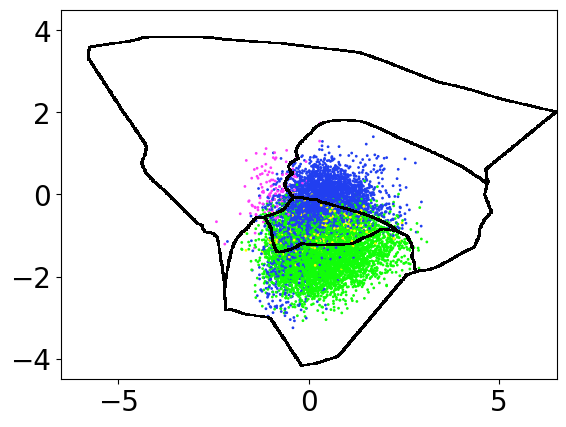

In [10]:
cell_line_dataset.plot(model, c=np.argmax(classification, axis=-1), cmap=Pmap, s=1)
plt.apply_boundary()

In [42]:
large_areas = df.sort_values('Area').tail(2)
large_areas

,Frames,CellNum,Area,CentroidX,CentroidY,MjrAxisLength,MnrAxisLength,Eccentricity,Orientation,ConvexArea,...,BlebLen,CenterX,CenterY,ActinEdge,Filopodia,Bleb,Lamellipodia,Class,Latent-0,Latent-1
7965,22,587,2093,232.882943,427.093168,61.210619,46.061972,0.658574,-48.505181,2188,...,22.97056,230,423,9.197253e-09,1.834479e-08,1.483392e-08,1.000000,3,2.530831,0.867225
9201,21,846,2298,224.190601,422.762402,72.508636,47.417045,0.756538,-39.403857,2705,...,34.04163,218,416,7.932545e-06,4.827137e-03,3.825675e-04,0.994782,3,1.698488,1.408053


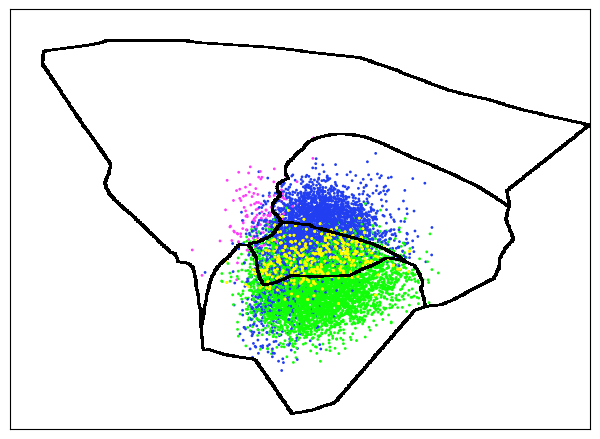

In [56]:
cell_line_dataset.plot(model, c=np.argmax(classification, axis=-1), cmap=Pmap, s=1)
plt.scatter2d(df[df['Class']==0][['Latent-0','Latent-1']].to_numpy(), s=1, c=df[df['Class']==0]['Class'].to_numpy(), cmap=Pmap)
plt.scatter2d(df[df['Class']==0][['Latent-0','Latent-1']].to_numpy(), s=1, c=df[df['Class']==0]['Class'].to_numpy(), cmap=Pmap)
plt.apply_boundary()
if SAVE_EXTRAS:
    plt.save(g_Base() + "Latent")

# Plot Segmentations

In [44]:
fnames = [fid_to_name[frame_id] for frame_id in increasing_frame_ids]
fnames[:3]

['MCF7_Phase_H4_1_00d00h00m_1.tif',
 'MCF7_Phase_H4_1_00d04h00m_1.tif',
 'MCF7_Phase_H4_1_00d08h00m_1.tif']

In [45]:
IMG_NUM = large_areas['Frames'].iloc[0]-1#41#47
s,c = np.unique(segmentations[increasing_frames[IMG_NUM]], return_counts=True)
s[np.argsort(c)[::-1]][:10],c[np.argsort(c)[::-1]][:10]

(array([  0, 587, 586, 526, 577, 525, 376, 454, 578, 585]),
 array([287440,   2093,   1415,   1356,   1095,    962,    856,    842,
           812,    735]))

In [69]:
def image_segmented(df, img_frame, _ax=None, fnames=None, alpha=0.5, s=1):
    if _ax is None:
        ax = plt.gca()
    else:
        ax = _ax
    try:
        im = plt.imread(f"{BASE_FOLDER}images/livecell_test_images/{fnames[img_frame]}")
        ax.imshow(im, cmap='gray')
    except:
        pass
    sdf = df[['CentroidX', 'CentroidY','Frames']].copy()
#     sdf = sdf[sdf['Frames'] == img_frame+1]
    sdf = sdf.to_numpy()
    plt.scatter2d(sdf, c=sdf[:,2], cmap='jet', alpha=alpha, s=s)

In [46]:
def image_segmented_phenotype(segmentations, df, frame_indicies, img_frame, _ax=None, fnames=None, alpha=0.5):
    if _ax is None:
        ax = plt.gca()
    else:
        ax = _ax
    TOL=2
    segmentation = segmentations[frame_indicies[img_frame],...]
    image_df = df[df['Frames'] == img_frame+1][['CellNum','Class','CentroidX','CentroidY']]
    phenotype = segmentation.copy()
    for cell_num in np.unique(segmentation):
        if cell_num == 0:
            continue
        cent = np.array(np.where(segmentation == cell_num)).mean(-1)
        sub_df = np.linalg.norm(image_df[['CentroidY','CentroidX']] - cent, axis=-1)
        cell_idx = np.argmin(sub_df)
        dist = sub_df[cell_idx]
        cell_df = image_df.iloc[cell_idx,:]
#         cell_df = image_df[image_df['CellNum'] == cell_num]
        cell_class = cell_df['Class']
        if dist > TOL:
            phenotype[segmentation==cell_num] = 0
        else:
            phenotype[segmentation==cell_num] = cell_class+1
    im = None
    _slice_x = slice(0,phenotype.shape[0])
    _slice_y = slice(0,phenotype.shape[1])
    try:
        im = plt.imread(f"{BASE_FOLDER}images/livecell_test_images/{fnames[img_frame]}")
        ax.imshow(im, cmap='gray')
        _slice_x = slice(0,im.shape[0])
        _slice_y = slice(0,im.shape[1])
    except:
        pass
    ax.imshow(np.ma.masked_equal(phenotype[_slice_x,_slice_y],0)-1, cmap=Pmap, alpha=alpha)

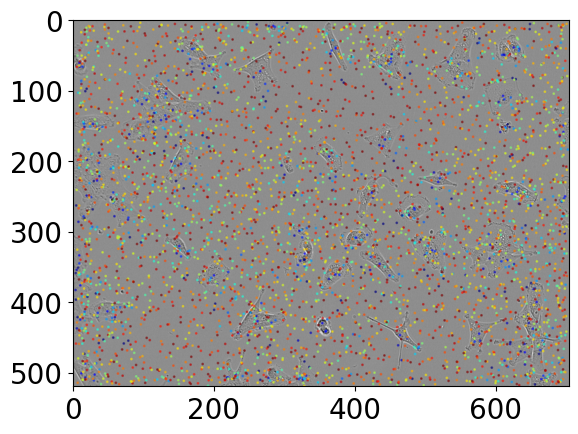

In [70]:
image_segmented(df, 2, fnames=fnames)

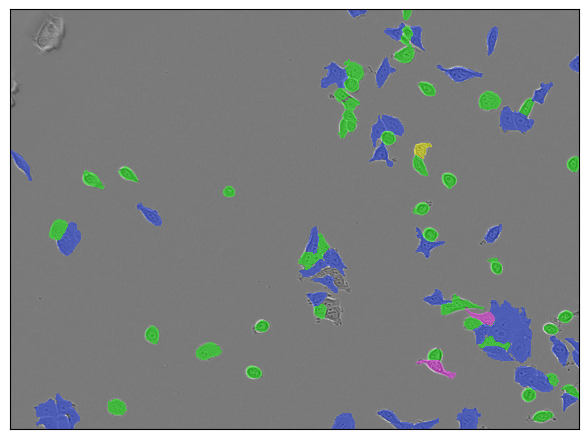

In [57]:
image_segmented_phenotype(segmentations, df, increasing_frames, 2, fnames=fnames)
if SAVE_EXTRAS:
    plt.save(g_Base() + "Segmentation")

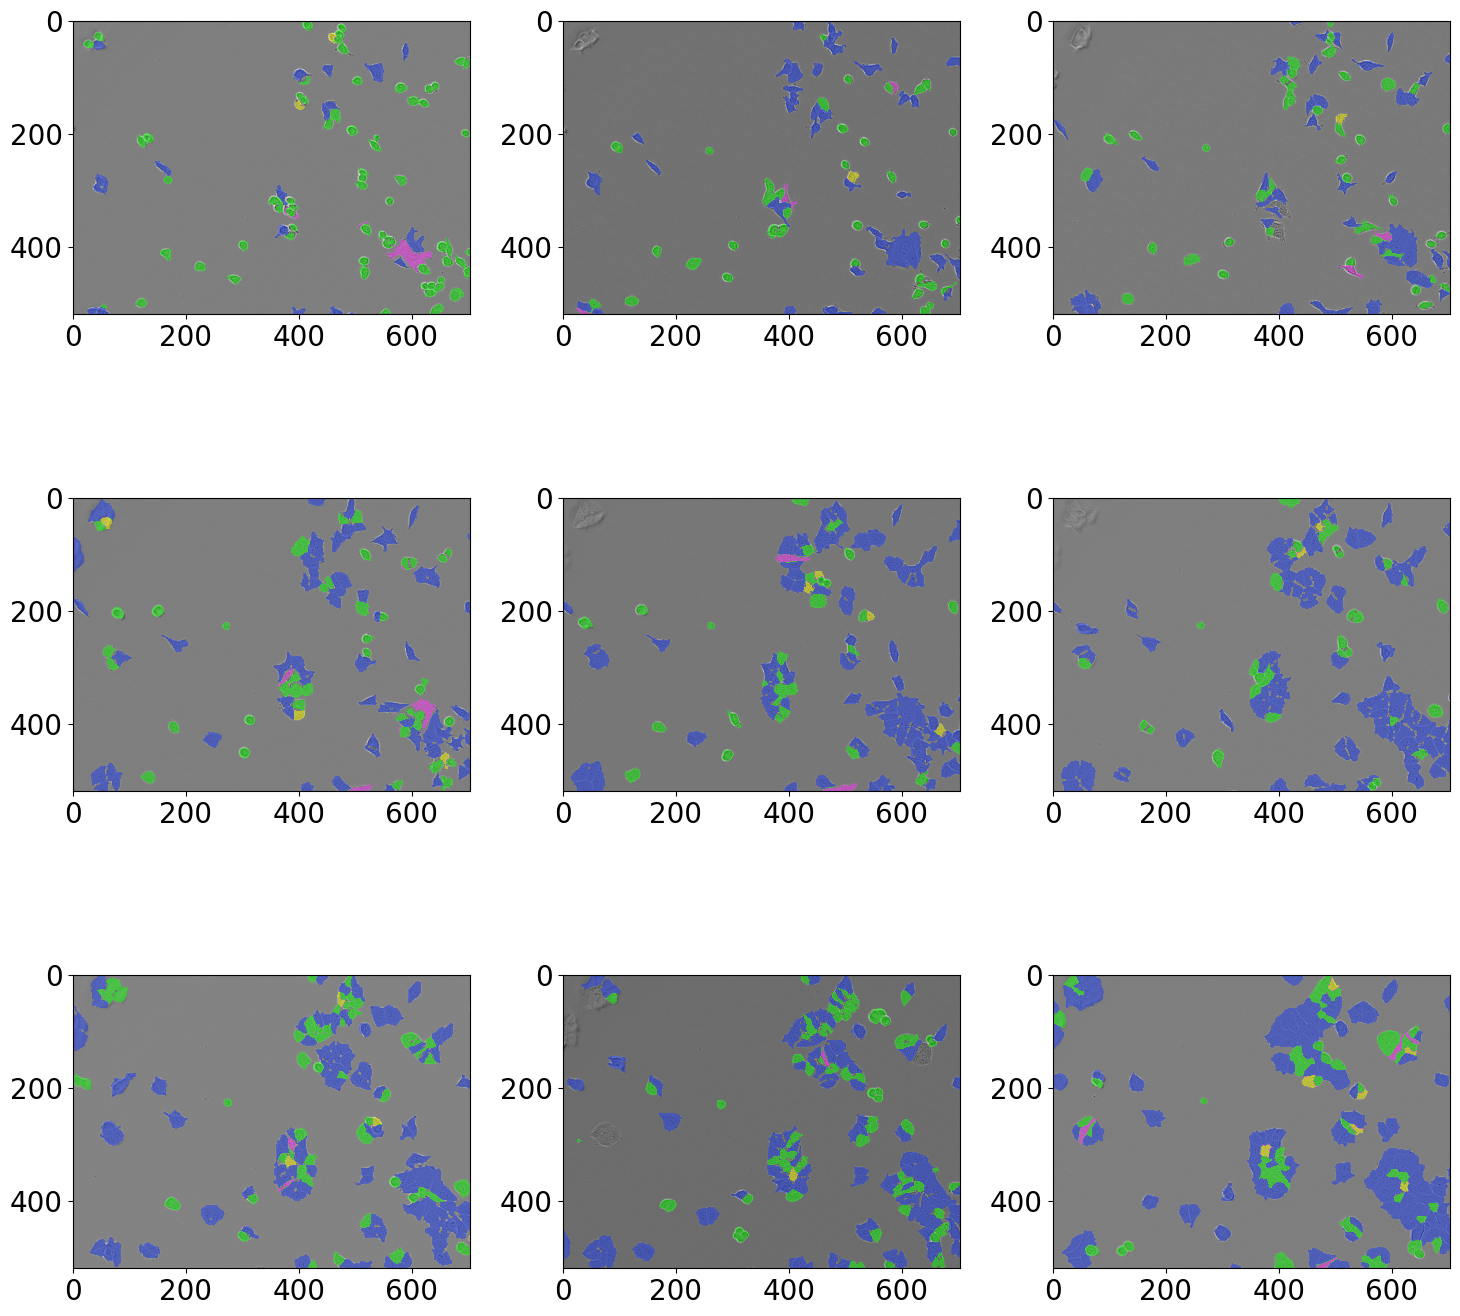

In [48]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
ax = ax.flatten()
for idx in range(len(ax)):
    image_segmented_phenotype(segmentations, df, increasing_frames, idx, _ax=ax[idx], fnames=fnames)
#     im = plt.imread(f"{BASE_FOLDER}images/livecell_test_images/{fnames[idx]}")
#     ax[idx].imshow(im, cmap='gray')
#     ax[idx].imshow(np.ma.masked_equal(segmentations[increasing_frames[idx],...], 0)[:im.shape[0],:im.shape[1]], alpha=0.5)
plt.tight_layout()

In [63]:
errors = np.mean(np.abs(cell_line_dataset.dataset-model.autoencoder(cell_line_dataset.dataset).numpy()),axis=-1)
errors.mean().round(3),errors.std().round(3),errors.max().round(3)

(0.025, 0.012, 0.106)

# END